In [59]:
import os
import torch
from torchvision import transforms
from glob import glob

from fov.segmentation.dataset import BinaryFovDataset


device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [60]:
class ToDevice:
    def __init__(self, device):
        self.device = device

    def __call__(self, image: torch.Tensor):
        return image.to(self.device)


# data transformations
trans = transforms.Compose([ToDevice(device=device)])


# set the dataset
splits = ["train", "val", "test"]
data_dir = "/data/shared/fov/fov_bev_segmentation"
datasets = {
    split: BinaryFovDataset(
        data_dir, transform=trans, transform_mask=trans, split=split
    )
    for split in splits
}

In [61]:
from avstack.config import Config, MODELS

# load model
cfg = Config.fromfile("../config/segmentation/unet_mc_dropout.py")
seg_model = MODELS.build(cfg["model"]).to(device)

# set the weights based on an epoch
epoch = -1
weight_dir = "../scripts/segmentation_training"
last_subdir = sorted(next(os.walk(weight_dir))[1])[-1]
if epoch == -1:
    weights_path = sorted(glob(os.path.join(weight_dir, last_subdir, "epoch*")))[-1]
else:
    epoch_str = f"epoch_{epoch}.pth"
    weights_path = os.path.join(weight_dir, last_subdir, epoch_str)

# load weights
seg_model.load_state_dict(torch.load(weights_path))
seg_model.eval()
seg_model.enable_eval_dropout()

A `UNetBinary` instance is built from registry, and its implementation can be found in fov.segmentation.models


In [97]:
# run MC prediction on an image
image, gt_mask = datasets["val"][30]
img_in = image.unsqueeze(0)
mask_bin, mask_mean, mask_std = predict_mc_dropout(
    seg_model, img_in, n_iters=10, threshold=0.7
)

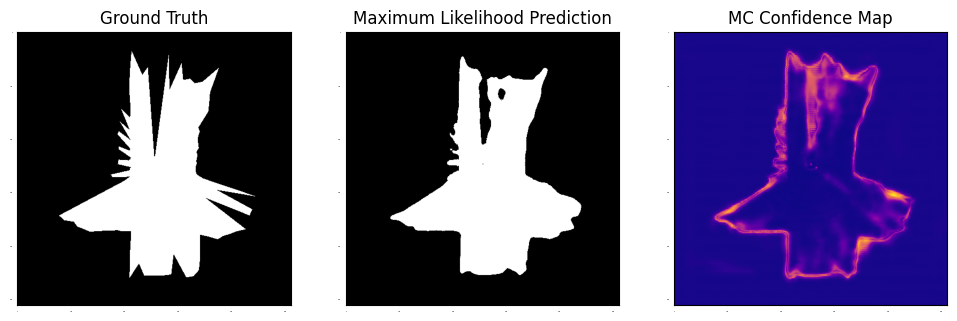

In [98]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(12, 6))

cmap_binary = "gray"
cmap_conf = "plasma"

# set up the tuples for loops
titles = ["Ground Truth", "Maximum Likelihood Prediction", "MC Confidence Map"]
cmaps = [cmap_binary, cmap_binary, cmap_conf]
masks = [gt_mask, mask_bin, mask_std]

# add the masks to plots
for ax, title, cmap, mask in zip(axs, titles, cmaps, masks):
    ax.imshow(mask.squeeze().cpu(), cmap=cmap)
    ax.tick_params(which="both", size=0, labelsize=0)
    ax.set_title(title)

plt.show()